# Test DataLoader

In this notebook we test several functionalities that are necessary to run the training and validation of the different odels. Namely, we test fitting data loaders with the corresponding dataset and visualizing the data in a batchwise fashion.

In [1]:
import os
import sys
import json

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import cv2

sys.path.append("..")

from CONFIG import CONFIG
import data
import data.data_processing as data_processing
import models
import lib.arguments as arguments
import lib.utils as utils
from lib.loss import PersonMSELoss
import lib.metrics as metrics
import lib.pose_parsing as pose_parsing
import lib.visualizations as visualizations
import CONSTANTS

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

In [4]:
exp_name = os.path.join("notebook_tests", "hrnet_notebook")
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
data_path = CONFIG["paths"]["data_path"]
img_path = os.path.join(data_path, "images", "train")
original_imgs_path = os.path.join(data_path, "original_images", "train2017")
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_train.json")
preds_file = os.path.join(test_exp, CONFIG["paths"]["submission"])

In [5]:
exp_data = utils.load_experiment_parameters(test_exp)
exp_data["training"]["batch_size"] = 1

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(
    mean=mean.tolist(), std=std.tolist()
)

# loss_function 

In [7]:
hrnet_dataset = data.HRNetCoco(exp_data=exp_data, root=data_path, img_path=img_path,
                               labels_path=labels_file, is_train=True,
                               is_styled=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   normalize,
                               ]))

Loading /home/corrales/MasterThesis/data/mapping_dicts/train_dict.json...
loading annotations into memory...
Done (t=9.71s)
creating index...
index created!


In [8]:
train_loader, valid_loader = data.data_loaders.load_dataset(exp_data=exp_data, shuffle_train=True, shuffle_valid=True)

Loading /home/corrales/MasterThesis/data/mapping_dicts/train_dict.json...
loading annotations into memory...
Done (t=9.62s)
creating index...
index created!
Loading /home/corrales/MasterThesis/data/mapping_dicts/valid_dict.json...
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


## Displaying Training Image

In [51]:
imgs, target, target_weight, metadata = next(iter(train_loader))

image_name = metadata["image"][0].split("/")[-1]

In [52]:
image_name

'000000243959_stylized_skyphos_athena promachos.jpg'

In [53]:
# sampling a person-crop and the annotatios  
imgs, target, target_weight, metadata = hrnet_dataset.get_all_samples_given_name(image_name)

n_humans = imgs.shape[0]
print(f"N People: {n_humans}")
full_img_path = metadata["image"][0]
full_img = cv2.imread(full_img_path, cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)

N People: 3


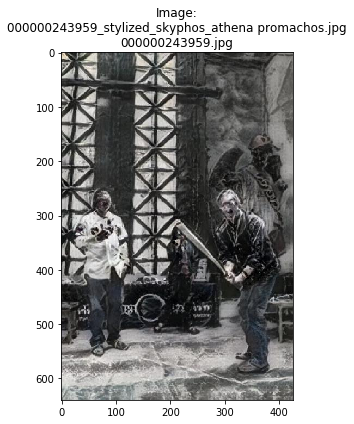

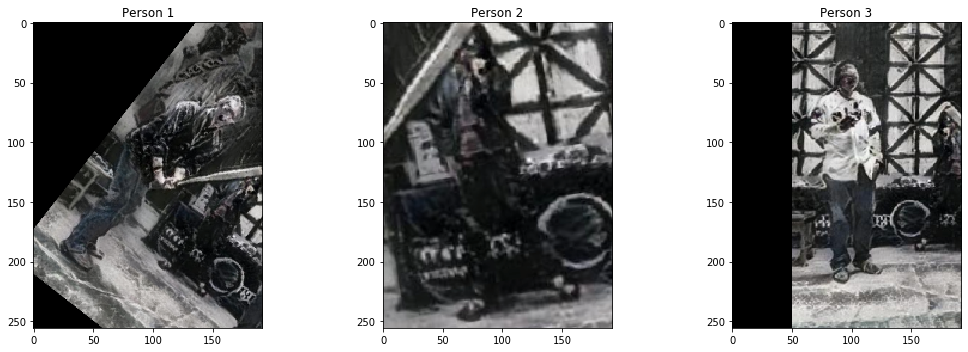

In [54]:
img_path = metadata["image"][0]
original_img_path = metadata["original_image"][0]

full_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
ax.imshow(full_img)
ax.set_title(f"Image:\n{img_path.split('/')[-1]}\n{original_img_path.split('/')[-1]}")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,n_humans)
fig.set_size_inches(5*n_humans, 5)
for i in range(n_humans):
    if(n_humans == 1):
        visualizations.visualize_image(np.array(imgs[i,:]), ax=ax, title=f"Person {i+1}")
    else:
        visualizations.visualize_image(np.array(imgs[i,:]), ax=ax[i], title=f"Person {i+1}")
plt.tight_layout()
plt.show()


In [55]:
# HRNet Model
hrnet = models.PoseHighResolutionNet(is_train=False)
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "HRnet", "pose_hrnet_w32_256x192.pth")
hrnet.load_state_dict(torch.load(pretrained_path))

<All keys matched successfully>

In [56]:
# we set the model to use the GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"  # for just one image we can simply use 'cpu'
hrnet = hrnet.to(device)
hrnet = hrnet.eval()

# defining loss function
loss_function = PersonMSELoss()

In [57]:
output = hrnet(imgs.float())
scaled_output = F.interpolate(output.clone().detach(), (256, 192),
                              mode="bilinear", align_corners=True)
n_images = output.shape[0]
n_joints = output.shape[1]

In [58]:
loss_value = loss_function(output, target, target_weight).item()
print(f"Loss Value: {round(loss_value,5)}")

# computing accuracy as validation metric
_, avg_acc, cnt, pred = metrics.accuracy(output.cpu().detach().numpy(),
                                         target.cpu().numpy())
print(f"Accuracy Value: {round(avg_acc,5)}")

Loss Value: 0.00074
Accuracy Value: 0.88235


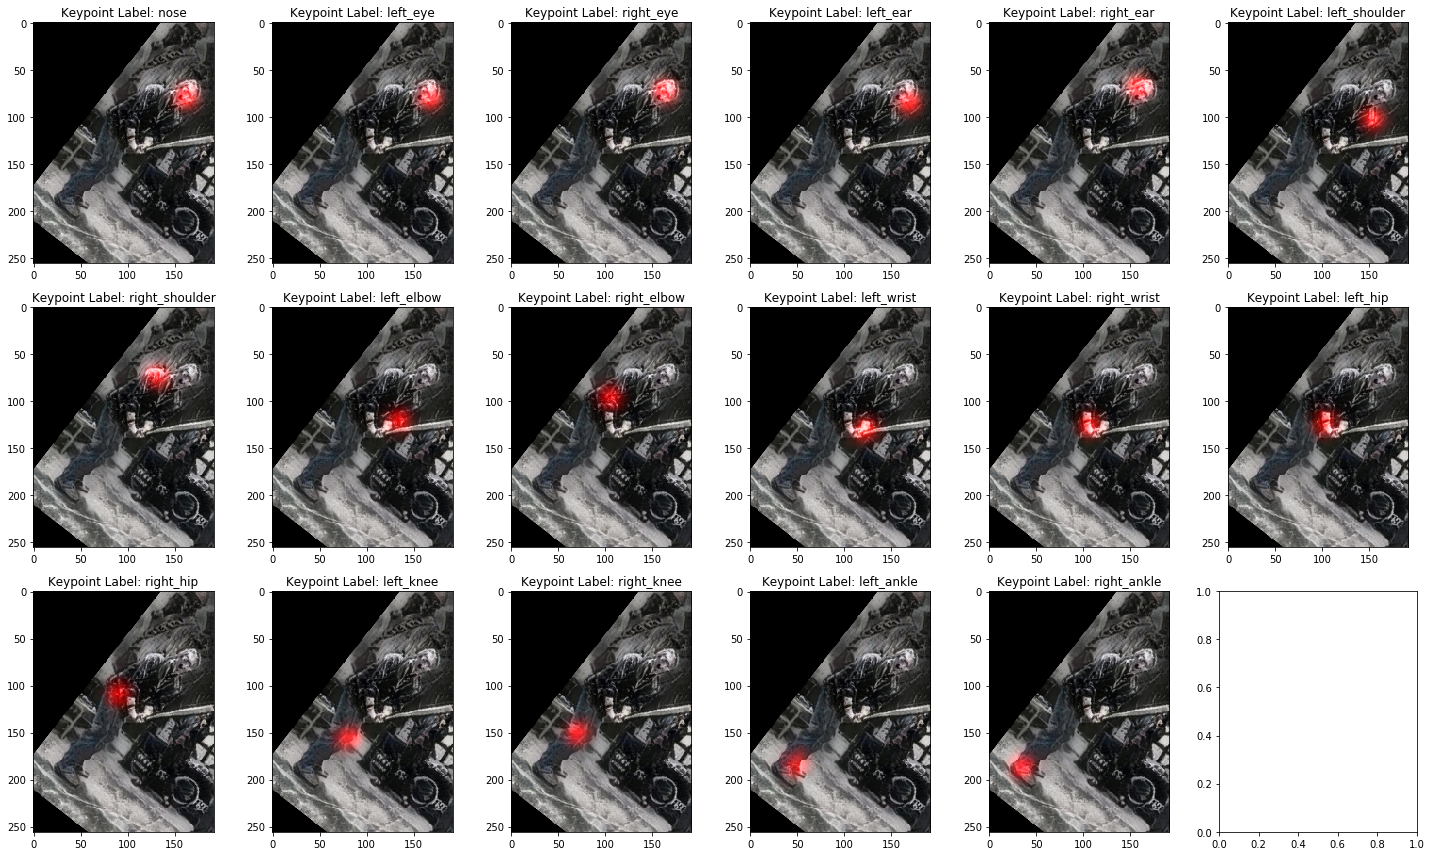

In [59]:
image_idx = 0

fig, ax = plt.subplots(3,6)
fig.set_size_inches(20,12)

for i in range(n_joints):
    row = i // 6
    col = i% 6
    title = f"Keypoint Label: {CONSTANTS.IDX_TO_KPT_NAME[i]}"
    visualizations.overlay_heatmap(heatmap=np.array(scaled_output[image_idx,i,:].cpu()), img=np.array(imgs[image_idx,:].cpu()),
                                   ax=ax[row, col], title=title)
plt.tight_layout()
plt.show()

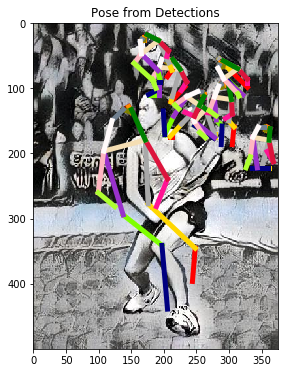

In [43]:
# pose parsing
centers = metadata["center"].numpy()
scales = metadata["scale"].numpy()
score = metadata["score"].numpy()

keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(output.cpu().detach().numpy(), centers, scales)
pose_entries, all_keypoints = pose_parsing.create_pose_entries(keypoints)

all_keypoints = [all_keypoints[:, 1], all_keypoints[:, 0], all_keypoints[:, 2], all_keypoints[:, 3]]
all_keypoints = np.array(all_keypoints).T


fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

title = "Pose from Detections"
visualizations.draw_pose(full_img, pose_entries, all_keypoints, ax=ax, title=title)

In [44]:
all_preds = np.zeros((n_humans, 17, 3), dtype=np.float32)
all_preds[:,:,:2] = keypoints[:,:,:2]
all_preds[:,:,2:3] = max_vals

all_boxes = np.zeros((n_humans, 6))
all_boxes[:, 0:2] = centers[:, 0:2]
all_boxes[:, 2:4] = scales[:, 0:2]
all_boxes[:, 4] = np.prod(scales*200, 1)
all_boxes[:, 5] = score

## Cheat

In [45]:
scaled_target = F.interpolate(target.clone().detach(), (256, 192),
                              mode="bilinear", align_corners=True)

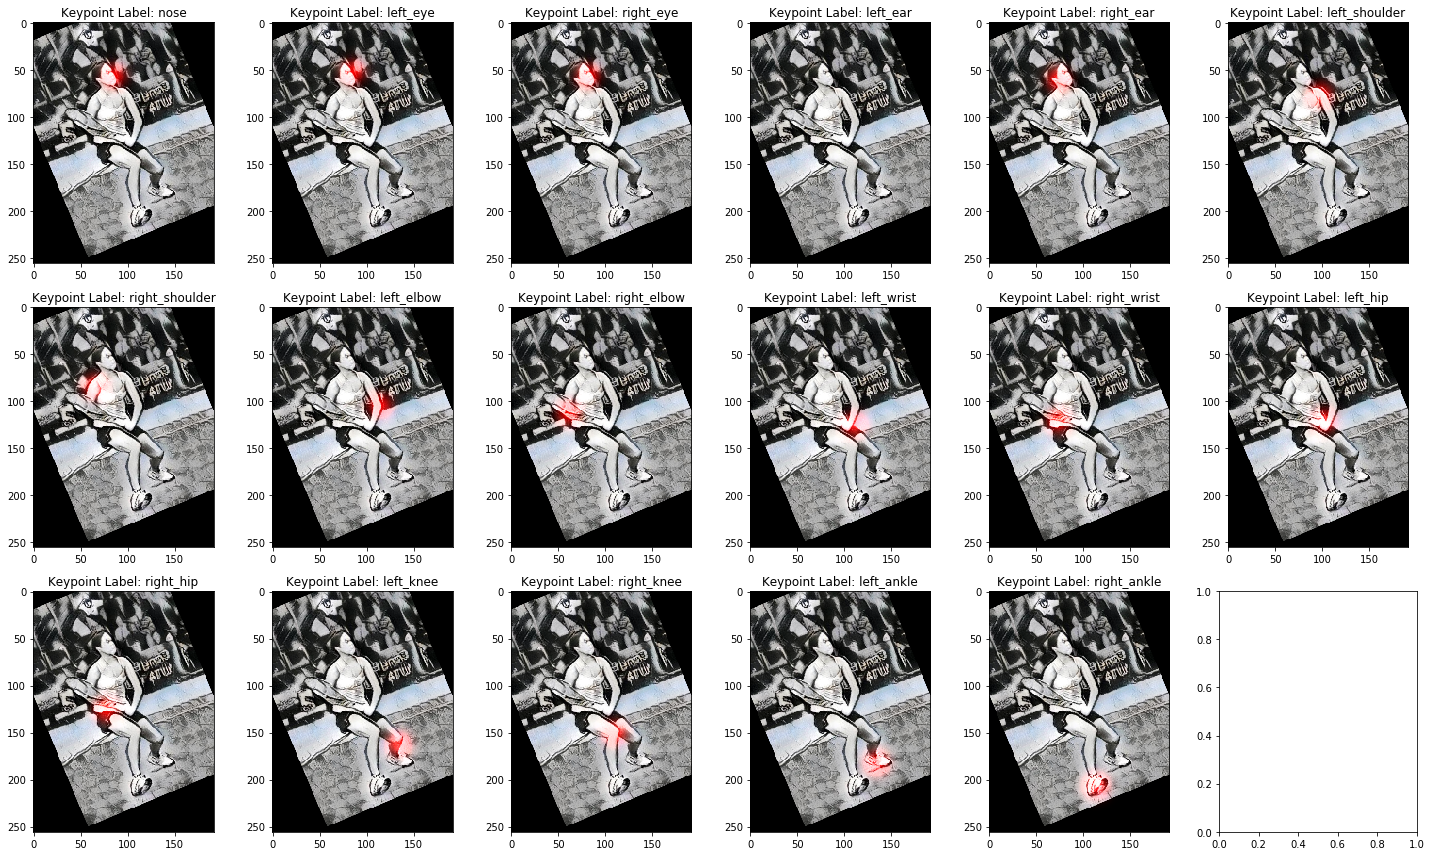

In [46]:
image_idx = 0

fig, ax = plt.subplots(3,6)
fig.set_size_inches(20,12)

for i in range(n_joints):
    row = i // 6
    col = i% 6
    title = f"Keypoint Label: {CONSTANTS.IDX_TO_KPT_NAME[i]}"
    visualizations.overlay_heatmap(heatmap=np.array(scaled_target[image_idx,i,:].cpu()), img=np.array(imgs[image_idx,:].cpu()),
                                   ax=ax[row, col], title=title)
plt.tight_layout()
plt.show()

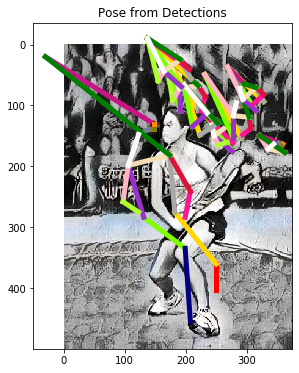

In [47]:
# pose parsing
centers = metadata["center"].numpy()
scales = metadata["scale"].numpy()
score = metadata["score"].numpy()

keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(target.cpu().detach().numpy(), centers, scales)
pose_entries, all_keypoints = pose_parsing.create_pose_entries(keypoints)

all_keypoints = [all_keypoints[:, 1], all_keypoints[:, 0], all_keypoints[:, 2], all_keypoints[:, 3]]
all_keypoints = np.array(all_keypoints).T


fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

title = "Pose from Detections"
visualizations.draw_pose(full_img, pose_entries, all_keypoints, ax=ax, title=title)

In [48]:
all_preds = np.zeros((n_humans, 17, 3), dtype=np.float32)
all_preds[:,:,:2] = keypoints[:,:,:2]
all_preds[:,:,2:3] = max_vals

all_boxes = np.zeros((n_humans, 6))
all_boxes[:, 0:2] = centers[:, 0:2]
all_boxes[:, 2:4] = scales[:, 0:2]
all_boxes[:, 4] = np.prod(scales*200, 1)
all_boxes[:, 5] = score

In [49]:
utils.reset_predictions_file(test_exp)
metrics.generate_submission_hrnet(all_preds=[all_preds], all_bboxes=[all_boxes], 
                                  image_names=[original_img_path]*n_humans, preds_file=preds_file)

In [50]:
stats = metrics.compute_precision(labels_file=labels_file, preds_file=preds_file)

loading annotations into memory...
Done (t=9.46s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.032
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.125
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | ma